# Finding Critical Points with TensorFlow
## Part 1a - Critical Points of Quadratic Forms - Newton's Method

The primary way to discover critical points is by augmenting gradient descent
with curvature information.
The resulting algorithm is called *Newton's Method*,
and it is also used to find minima in problems
where the only critical points are minima,
a subset of what are known as *convex* problems.

Essentially,
we want to step more carefully in directions where the curvature is high
and more aggressively in directions where the curvature is small.
This corresponds to multiplying the gradient vector by the inverse of the Hessian matrix
to get our update:

$$
\theta^{t+1} = \theta^{t} - \gamma \left(\nabla^2 f(\theta)\right)^{-1}\nabla f(\theta)
$$

where we've also included a new step-size parameter $\gamma$.

This method is attracted to all kinds of critical points.
Of course, when there are critical points other than minima,
Newton's Method is not a great choice of optimizer:
it might end up at a saddle point,
or even a maximizer!
But this very property makes it a good choice of algorithm
for finding critical points.

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white")

import numpy as np

import crit_finder

%matplotlib inline

### Testing with Identity Matrix

The identity matrix is a good sanity check for the Newton Method since, if we set the `newton_rate`, or the learning rate of the Newton method, to exactly $1$, then we should get convergence in a single step.

The value that minimizes the identity matrix is the same that minimizes any positive definite quadratic form: $\mathbf{0}$, the zero vector.

In [2]:
N = 2

identity_matrix = np.eye(N).astype(np.float32)

initial_values = np.random.standard_normal(size=N).astype(np.float32)

identity_quadratic_form = crit_finder.make_quadratic_form(identity_matrix, initial_values,
                                                                 crit_finder.DEFAULTS)

In [3]:
final_output, final_parameters = crit_finder.minimize(identity_quadratic_form, "newton", 1)

assert final_output == 0
assert np.array_equal(final_parameters, [0,0])

### Random Symmetric Matrices

As before,
we want to check our reasoning and code on randomly selected quadratic forms,
not just on the identity matrix.

It's important, however, to determine what notion of "randomness"
is most appropriate.
Since we are essentially modeling Hessians,
we know that the entries will be real and,
for most functions,
[symmetric](https://en.wikipedia.org/wiki/Symmetry_of_second_derivatives).

The canonical choice for a distribution over real symmetric matrices is the
[Gaussian ensemble](https://en.wikipedia.org/wiki/Random_matrix).
A member of the (normalized) Gaussian ensemble of rank $N$
is a random $N\times N$ symmetric matrix
whose upper triangular entries are distributed as

$$
Q_{ij} \sim \mathcal{N}\left(0, \frac{1}{\sqrt{2N}}\right)
$$

and whose lower-triangular entries are equal to the upper-triangular entries.

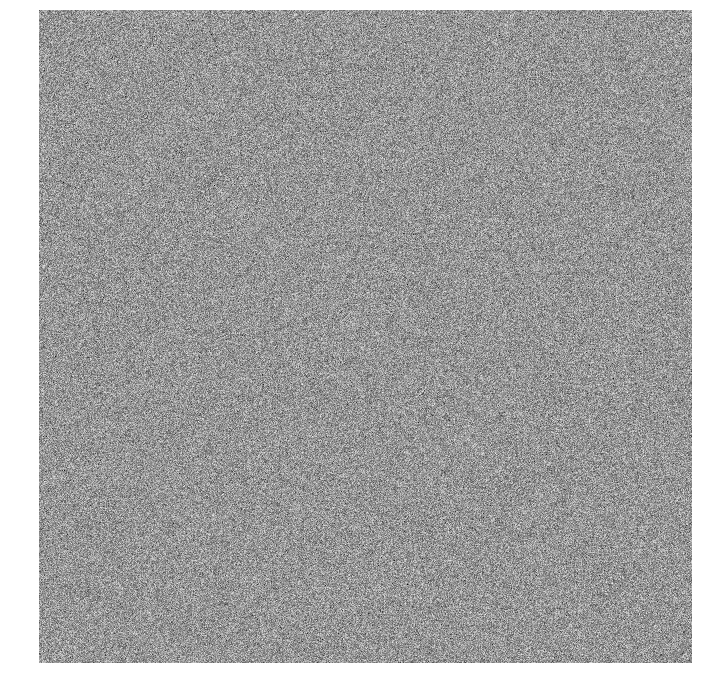

In [4]:
def generate_gaussian(N):
    return 1/np.sqrt(N)*np.random.standard_normal(size=(N,N)).astype(np.float32)

def generate_symmetric(N):
    base_matrix = generate_gaussian(N)
    return (1/np.sqrt(2))*(base_matrix+base_matrix.T)

N = 1000

random_symmetric_matrix = generate_symmetric(N)

plt.figure(figsize=(12,12))
plt.imshow(random_symmetric_matrix,cmap="Greys");
plt.axis('off');

Despite (or from another perspective, because of)
the apparent structureless of such matrices,
they have a stereotypical, analytically derived
expected spectrum:
the [Wigner semicircle distribution](https://en.wikipedia.org/wiki/Wigner_semicircle_distribution)
with radius 2.

$$
\rho(\lambda) = \frac{1}{2\pi}\sqrt{2^2-\lambda^2}
$$

Or, in Python:

In [5]:
def wigner_semicircle(lam):
    return 1/(2*np.pi)*np.sqrt(2**2-lam**2)

We can confirm we're sampling from the random matrix distribution we think we are
by checking the spectrum of samples against the expected spectrum.

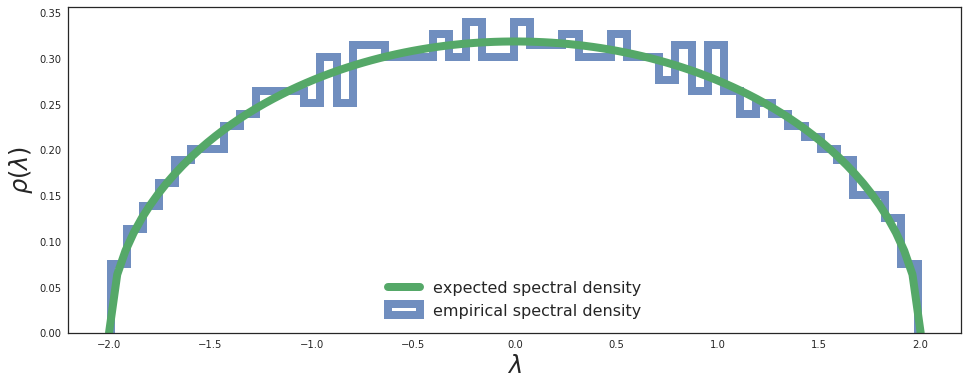

In [6]:
eigvals, _ = np.linalg.eigh(random_symmetric_matrix)

plt.figure(figsize=(16,6))
sns.distplot(eigvals, kde=False, bins=max(N//20,10),
             hist_kws={"normed":True, "histtype":"step", "linewidth":8, "alpha":0.8},
            label="empirical spectral density");
lams = np.linspace(-2, 2, 100);
plt.plot(lams,wigner_semicircle(lams),linewidth=8, label="expected spectral density");
plt.ylabel(r"$\rho\left(\lambda\right)$", fontsize=24); plt.xlabel(r"$\lambda$", fontsize=24);
plt.legend(fontsize=16, loc=8);

The behavior of Newton's method is determined by the
[condition number](https://en.wikipedia.org/wiki/Condition_number),
$\kappa$,
of the function it is applied to.
In general,
the condition number is the ratio of
the curvature in the curviest direction at any point
to the curvature in the flattest direction at any point.

For a quadratic form,
the condition number is given by the ratio of
the eigenvalue with largest magnitude
to the eigenvalue with smallest magnitude:

$$
\kappa = \frac{\beta}{\alpha}
$$

The larger this number is, the worse the convergence rate of Newton's Method will be.

In [7]:
initial_values = 1/np.sqrt(N)*np.random.standard_normal(size=N).astype(np.float32)

random_symmetric_quadratic_form = crit_finder.make_quadratic_form(random_symmetric_matrix, initial_values,
                                                                 crit_finder.DEFAULTS)

eigvals, _ = np.linalg.eigh(random_symmetric_matrix)

alpha = min(abs(eigvals))
beta = max(abs(eigvals))

kappa = beta/alpha
kappa

2570.4548

<!-- #TODO: confirm that this holds for our problem
Speedy convergence of Newton's Method
[can be guaranteed](https://web.stanford.edu/class/msande311/lecture13.pdf)
if the Euclidean distance from the initial point to the critical point
is less than $\kappa^{-1}$.
That's bad news for us,
but it seems like it's not necessary condtion. -->

Since we know the location of the critical point,
we can test our algorithms by checking the Euclidean distance to that point.

The cells below check this distance
after two steps of Newton's Method
and after two steps of gradient descent
from a single initialization.
In general,
Newton's Method finds a point with
low norm very quickly.

In [8]:
N = 1000

initial_values = 1/np.sqrt(N)*np.random.standard_normal(size=N).astype(np.float32)

random_symmetric_matrix = generate_symmetric(N)

random_symmetric_quadratic_form = crit_finder.make_quadratic_form(random_symmetric_matrix, initial_values,
                                                                 crit_finder.DEFAULTS)

_, values = crit_finder.minimize(random_symmetric_quadratic_form, "newton", 2)

np.sqrt(np.linalg.norm(values))

0.00023636676

In [9]:
_, values = crit_finder.minimize(random_symmetric_quadratic_form, "gradient_descent",2)

np.sqrt(np.linalg.norm(values))

0.99977463

We can also compare the performance on our figure of merit,
the gradient norm,
across different random symmetric matrices and random initializations.
Note that this is the only method that will generalize to functions other than quadratic forms,
since calculating the distance to the critical point
required us to know where that critical point was.

In [10]:
methods = ["gradient_descent", "newton"]

results = crit_finder.compare_descent_methods(generate_symmetric, N,
                                               num_steps=2, num_matrices=10, num_runs=10,
                                              methods=methods,
                                              hyperparameters=crit_finder.DEFAULTS)

The first plot below shows
the gradient norm across the first two iterations
for gradient descent and the Newton method.
Gradient norms are normalized by the gradient norm at the initial point.

The second plot shows the benefit of the Newton method on a more precise basis:
if I start from the exact same point on the exact same function,
what is the difference between the value obtained by gradient descent
and the value obtained by the Newton method.

The fact that all of the dots are below 0 indicates that Newton's method is *always* a better choice.

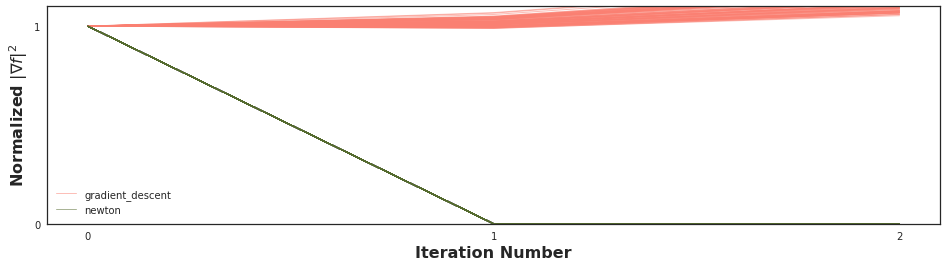

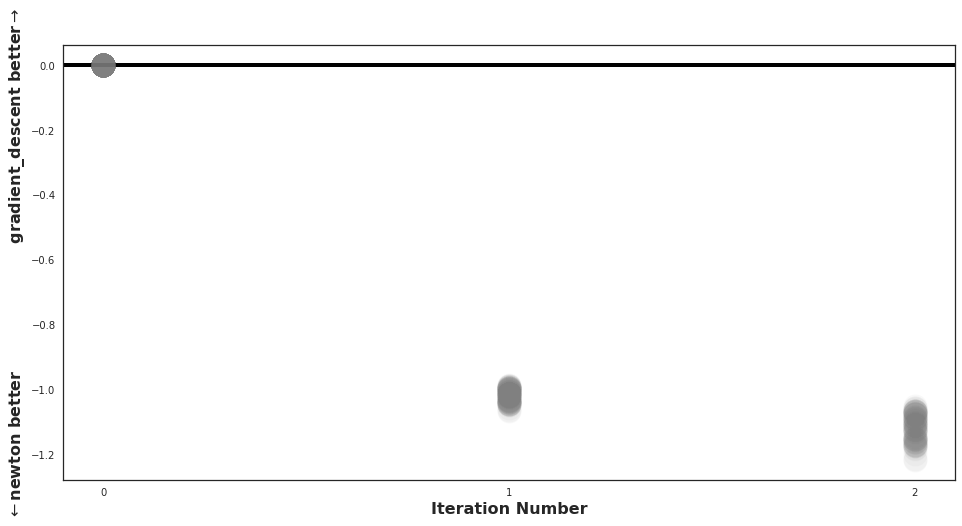

In [11]:
normalized_results = crit_finder.normalize_runs(results)

crit_finder.plot_trajectories_comparison(normalized_results, methods=methods)

crit_finder.plot_benefit(normalized_results, methods)

As expected,
gradient descent finds directions of descent on the function value
which take it away from the origin,
while the Newton method very quickly
gets close to the origin.

### Random Positive Definite Matrices

But we don't expect that the Hessians of neural networks will, in fact,
behave as if they were drawn from the Gaussian ensemble,
even approximately. 
A better approximation,
under certain assumptions, is that they are drawn from the
[Wishart distribution](https://en.wikipedia.org/wiki/Wishart_distribution),
which is generated by taking the outer product of a Gaussian random vector with itself.
See [Pennington and Bahri, 2017](https://research.google.com/pubs/pub46120.html) for more details.

The spectra of these matrices should roughly follow the
[Marçenko-Pastur distribution](https://en.wikipedia.org/wiki/Marchenko%E2%80%93Pastur_distribution),
which frequently produces eigenvalues that are close to or exactly $0$,
but also produces eigenvalues of order $1$.
These matrices are therefore often quite ill-conditioned.

This is a problem for the Newton method,
which relies on inverting the Hessian -- a Hessian with some eigenvalues equal to $0$ is not invertible!
Of course, on a computer,
values within $\epsilon$ of $0$ are also non-invertible,
for some values of $\epsilon$.

A full-rank Wishart matrix can sometimes be numerically inverted.
Running the cells below will give you a sense of how often this operation fails.

In [12]:
def generate_wishart(N):
    self_outer_product = lambda x: x.dot(x.T)
    wishart_random_matrix = 1/N*self_outer_product(np.random.standard_normal(size=(N,1))).astype(np.float32)
    
    return wishart_random_matrix

In [13]:
N = 5

wishart_random_matrix = generate_wishart(N)

initial_values = np.random.standard_normal(size=N).astype(np.float32)

wishart_quadratic_form = crit_finder.make_quadratic_form(wishart_random_matrix, initial_values,
                                                                 crit_finder.DEFAULTS)

In [14]:
try: 
    crit_finder.minimize(wishart_quadratic_form, "newton", 1)
except tf.errors.InvalidArgumentError:
    hessian = crit_finder.get_result("hessian", initial_values, wishart_quadratic_form)    
    smallest_eigenvalue = np.min(np.linalg.eigvalsh(hessian))
    print("the inversion failed and")
    print("\t the hessian's smallest eigenvalue is {0}".format(smallest_eigenvalue))
    assert np.isclose(smallest_eigenvalue, 0, atol=1e-05)
else:
    print("the inversion succeeded ")
    

the inversion failed and
	 the hessian's smallest eigenvalue is -7.299199467070139e-09


We have two methods for getting around this.
You might call them *pseudo-inverses*,
but a more proper term would be *approximate inverses*.

#### Pseudo-Inverse Method #1: Fudging

The first method is *fudging*.
Just adding a very small number to the diagonal of the Hessian
adds that small number to all of its eigenvalues (think traces).
This has the effect of shrinking step sizes
(often substantially) in the directions of extreme flatness.

We still generically see better performance for one step of the fudged Newton method than one step of gradient descent.

In [15]:
N = 5

wishart_random_matrix = generate_wishart(N)

initial_values = np.random.standard_normal(size=N).astype(np.float32)

wishart_quadratic_form = crit_finder.make_quadratic_form(wishart_random_matrix, initial_values,
                                                                 {"learning_rate":0.1,
                                                                 "newton_rate":1,
                                                                 "fudge_factor":10e-7,
                                                                 "inverse_method":"fudged"})

In [16]:
crit_finder.minimize(wishart_quadratic_form, "newton", 1)

(1.6563594e-05,
 array([-0.8060267 ,  0.8400702 , -0.32796448, -0.45807034, -0.5360906 ],
       dtype=float32))

In [17]:
crit_finder.minimize(wishart_quadratic_form, "gradient_descent", 1)

(0.60591143,
 array([-1.3503295 ,  0.8904352 ,  0.9109719 , -0.8178111 , -0.06316016],
       dtype=float32))

In [18]:
results = crit_finder.compare_descent_methods(generate_wishart, N,
                                               num_steps=2, num_matrices=20, num_runs=10,
                                              hyperparameters={"learning_rate":0.1, "newton_rate":1,
                                                               "fudge_factor":1e-6, "inverse_method":"fudged"})

In [19]:
normalized_results = crit_finder.normalize_runs(results)

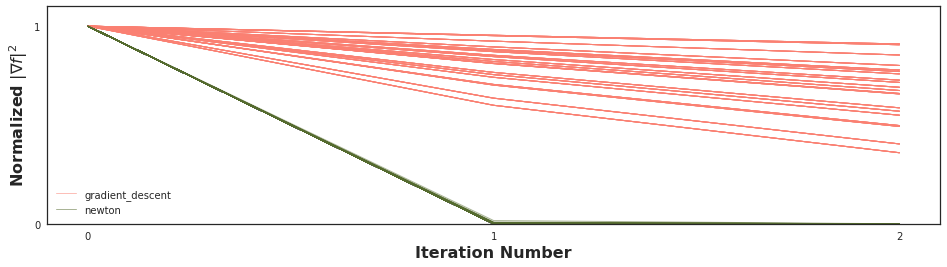

In [20]:
crit_finder.plot_trajectories_comparison(normalized_results)

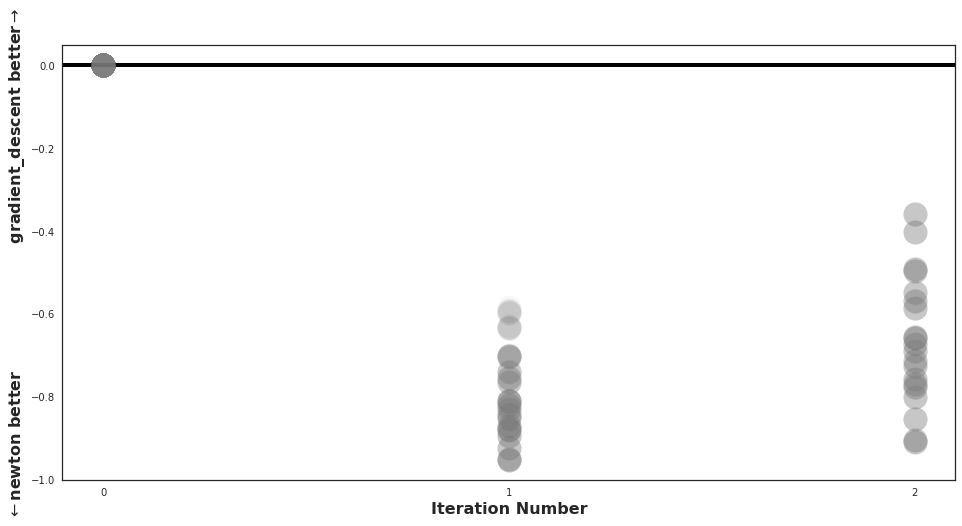

In [21]:
crit_finder.plot_benefit(normalized_results)

Notice that gradient descent is slightly more competitive in this setting.
This is because the attractor for gradient descent
is also the point where the gradient norm is minimized.

If we want to look at individual runs,
we use the `gradient_test` method.

In [22]:
crit_finder.gradient_test(N=5, matrix_generator=generate_wishart, algorithm="newton",
                           num_steps=2, hyperparameters={"learning_rate":0.1,
                                                                 "newton_rate":1,
                                                                 "fudge_factor":1e-6,
                                                                 "inverse_method":"fudged"})

output:
	initial: 2.2849390506744385 	final: 3.13750933855772e-06
gradient norm:
	initial: 3.001343250274658 	final: 0.003503400133922696


Our Hessians are large -- order one million entries, at the minimum.
We should ensure our method works on large matrices

On `redwood1`, which has around 30 gigabytes of memory,
I can reliably minimize these quadratic forms without memory or numerical error
up to at least `N=5000`,
or 25,000,000 entries in the Hessian.

In [23]:
crit_finder.gradient_test(N=1000, matrix_generator=generate_wishart, algorithm="newton",
                           num_steps=2, hyperparameters={"learning_rate":0.1,
                                                                 "newton_rate":1,
                                                                 "fudge_factor":1e-6,
                                                                 "inverse_method":"fudged"})

output:
	initial: 1.173518419265747 	final: -8.822098607197404e-08
gradient norm:
	initial: 1.4990627765655518 	final: 1.0319306966266595e-05


One issue is that the `newton_rate` parameter is quite finicky:
if it's not within an order of magnitude of the proper value,
it either fails to converge or explodes.

In [24]:
# low newton_rate, progress is sluggish

crit_finder.gradient_test(N=100, matrix_generator=generate_wishart, algorithm="newton", num_steps=2,
              hyperparameters={"learning_rate":0.1, "newton_rate":0.1,
                               "fudge_factor":1e-6, "inverse_method":"fudged"})

output:
	initial: 0.002595219761133194 	final: 0.0016826968640089035
gradient norm:
	initial: 0.07080299407243729 	final: 0.05701149255037308


In [25]:
# high newton_rate, progress is negative

crit_finder.gradient_test(N=100, matrix_generator=generate_wishart, algorithm="newton", num_steps=2,
              hyperparameters={"learning_rate":0.1, "newton_rate":10,
                               "fudge_factor":1e-6, "inverse_method":"fudged"})

output:
	initial: 0.005305546335875988 	final: 35.10666275024414
gradient norm:
	initial: 0.09493043273687363 	final: 7.722115993499756


#### Pseudo-Inverse Method 2: Drazin Pseudo-Inverse

There's another method for handling non-invertible matrices:
just ignoring the parts that are not invertible
and inverting the rest.

Concretely,
we first compute the eigenvalues and eigenvectors of the Hessian,
and then retain those eigenvalues whose magnitude
is greater than some threshold.
We then compute an outer product of those eigenvectors
and scale it by the inverse eigenvalues
to invert the matrix.

That is, we take one formula for the matrix inverse

$$
A^{-1} = \sum_i v_i\lambda_i^{-1}v_i^\intercal
$$

(where each $v_i, \lambda_i$ is a paired eigenvector and eigenvalue)
and simply restrict the sum
to those elements which have eigenvalues sufficiently far from $0$.

This is a proper method of "pseudo-inversion":
the result is a matrix with certain algebraic properties
that generalize inverses,
rather than a matrix that is simply an approximate inverse.
There are several notions of pseudo-inverse.
This method corresponds to the
[Drazin](https://en.wikipedia.org/wiki/Drazin_inverse)
pseudo-inverse.

All of the observations above hold for this method as well
-- including the sensitivity of the `newton_rate` hyperparameter.

In [26]:
N = 5

wishart_random_matrix = generate_wishart(N)

initial_values = np.random.standard_normal(size=N).astype(np.float32)

wishart_quadratic_form = crit_finder.make_quadratic_form(wishart_random_matrix, initial_values,
                                                                 {"learning_rate":0.1,
                                                                 "newton_rate":1,
                                                                 "minimum_eigenvalue_magnitude":1e-5,
                                                                 "inverse_method":"pseudo"})

In [27]:
crit_finder.minimize(wishart_quadratic_form, "newton", 1)

(-6.742308e-09,
 array([ 1.3757726 , -1.0132601 , -1.664862  ,  0.96470165, -0.35294765],
       dtype=float32))

In [28]:
crit_finder.minimize(wishart_quadratic_form, "gradient_descent", 1)

(0.6959215,
 array([ 1.6194917 , -1.1395482 , -1.5275182 ,  1.0459399 ,  0.53380394],
       dtype=float32))

In [29]:
crit_finder.gradient_test(N=5, matrix_generator=generate_wishart, num_steps=2, algorithm="newton",
                          hyperparameters={"learning_rate":0.1, "newton_rate":1,
                                       "minimum_eigenvalue_magnitude":1e-5,
                                       "inverse_method":"pseudo"})

output:
	initial: 0.10845685750246048 	final: -7.400948742741775e-10
gradient norm:
	initial: 0.5083133578300476 	final: 4.516254481501392e-09


In [30]:
crit_finder.gradient_test(N=1000, matrix_generator=generate_wishart, num_steps=2, algorithm="newton",
                          hyperparameters={"learning_rate":0.1, "newton_rate":1,
                                       "minimum_eigenvalue_magnitude":1e-5,
                                       "inverse_method":"pseudo"})

output:
	initial: 0.40027374029159546 	final: -2.1631654689713287e-08
gradient norm:
	initial: 0.9015707969665527 	final: 2.4797574837975844e-07


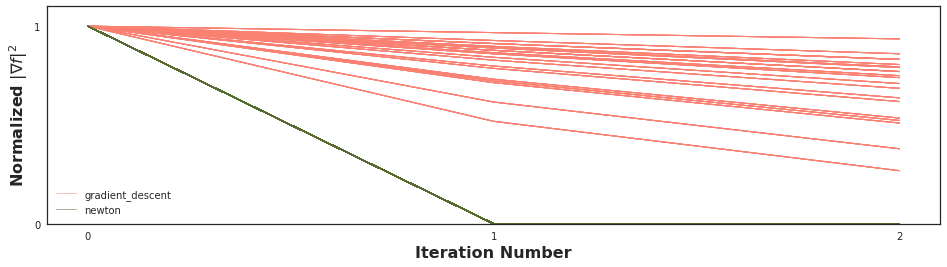

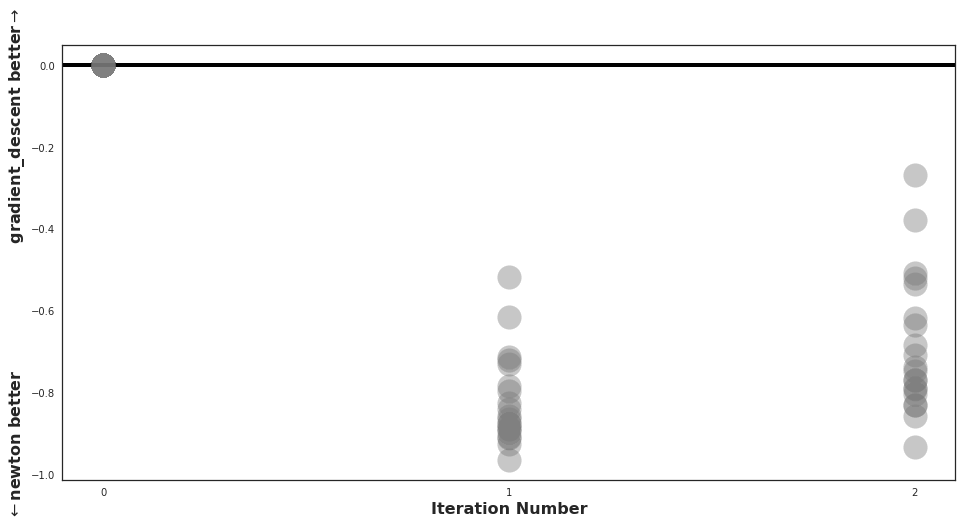

In [31]:
results = crit_finder.compare_descent_methods(generate_wishart, N,
                                               num_steps=2, num_matrices=20, num_runs=10,
                                              hyperparameters={"learning_rate":0.1, "newton_rate":1,
                                                               "minimum_eigenvalue_magnitude":1e-5,
                                                               "inverse_method":"pseudo"})
normalized_results = crit_finder.normalize_runs(results)
crit_finder.plot_trajectories_comparison(normalized_results)
crit_finder.plot_benefit(normalized_results)

### But Wait!

Just because the gradient norm is going down towards $0$
doesn't mean that we've found an *analytical* critical point!
It just means that we've found a *numerical* critical point,
or a point where the first order approximation is close to $0$.

For matrices with very small eigenvalues,
the numerical critical points might be an uncountable set,
since each point in the space spanned by the eigenvectors
with eigenvalues below a given threshold
will be a numerical critical point,
as will any point close enough to those spaces.

First, we check to see whether we're finding the analytical critical point
by comparing the norm of the solution to the norm of the random initial point
(which actually has norm $\approx 1$).

In [32]:
N = 10

wishart_random_matrix = generate_wishart(N)

initial_values = 1/np.sqrt(N)*np.random.standard_normal(size=N).astype(np.float32)

wishart_quadratic_form = crit_finder.make_quadratic_form(wishart_random_matrix, initial_values,
                                                                 {"learning_rate":0.1,
                                                                 "newton_rate":1,
                                                                 "minimum_eigenvalue_magnitude":1e-6,
                                                                 "inverse_method":"pseudo"})

In [33]:
output, values = crit_finder.minimize(wishart_quadratic_form, "newton", 1)

np.linalg.norm(values)/np.linalg.norm(initial_values)

0.967857

And indeed, the norm of the solution has not gone down,
even though the norm of the gradient has.

We can eigendecompose the random matrix
to determine the condition number,
and the answer we get is absurdly high --
between `1e9` and `1e12`.

In [34]:
eigvals, _ = np.linalg.eigh(wishart_random_matrix)

alpha = min(abs(eigvals))
beta = max(abs(eigvals))

kappa = beta/alpha
np.log10(kappa)

10.860146

For each eigenvector with eigenvalue magnitude below the threshold of the pseudo-inverse method,
we will have one direction in which our Newton method is unable to minimize the gradient norm.
Therefore it's important to ask in how many directions the function appears numerically flat.

In [35]:
np.mean(np.less(1e-6,eigvals))

0.1

To confirm that the above model is accurate,
we construct some diagonal matrices with known condition numbers
and a known fraction of equally flat directions,
then run Newton method, 
using the pseudo-inverse with a fixed eigenvalue magnitude threshold,
for one step,
confirming that the gradient norm has indeed decreased below a threshold.

The resulting solution norms are plotted below.

In [36]:
def condition_test(kappas, N=1000, k=100, hyperparameters=crit_finder.DEFAULTS):

    results = []

    initial_values = 1/np.sqrt(N)*np.random.standard_normal(size=N).astype(np.float32)

    for kappa in kappas:
        eigvals = [1]*(N-k)+k*[1/kappa]
        matrix = np.diag(eigvals).astype(np.float32)

        quadratic_form = crit_finder.make_quadratic_form(matrix, initial_values, hyperparameters)
        
        _, values = crit_finder.minimize(quadratic_form, "newton", 1)

        gradients = crit_finder.get_result("gradients", values, quadratic_form)[0]

        if np.linalg.norm(gradients)>1e-4:
            print("convergence failed on kappa={0}".format(kappa))
            results.append(np.inf)
            continue

        results.append(np.linalg.norm(values))
    
    return results
    
N = 1000
k = 1
kappas = np.logspace(0,11, num=20)
minimum_eigenvalue_magnitude = 1e-6
hyperparameters = {"learning_rate":0.1, "newton_rate":1,
                   "minimum_eigenvalue_magnitude":minimum_eigenvalue_magnitude,
                   "inverse_method":"pseudo"}

one_flat_results = condition_test(kappas, N, k, hyperparameters)

k=10
ten_flat_results = condition_test(kappas, N, k, hyperparameters)

k=100
hundred_flat_results = condition_test(kappas, N, k, hyperparameters)

k=500
half_flat_results = condition_test(kappas, N, k, hyperparameters)

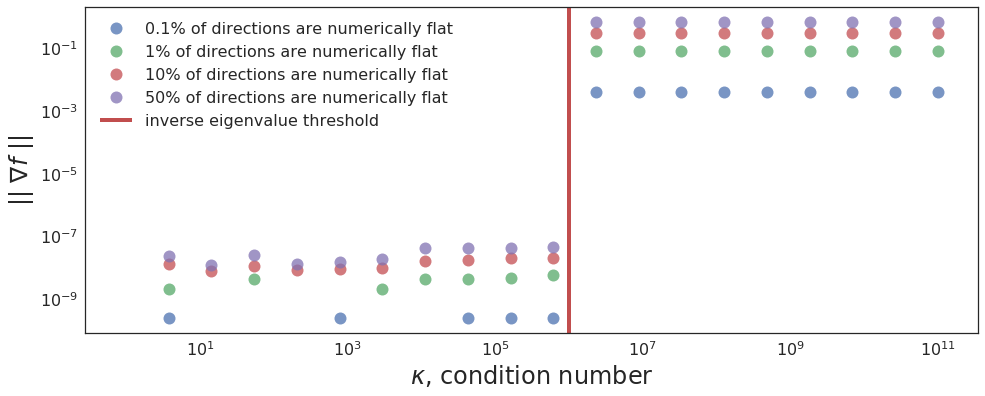

In [37]:
plt.figure(figsize=(16,6))
plt.loglog(kappas, one_flat_results, label="0.1% of directions are numerically flat",
             linestyle='None', marker='.', markersize=24, alpha=0.75);
plt.plot(kappas, ten_flat_results, label="1% of directions are numerically flat",
             linestyle='None', marker='.', markersize=24, alpha=0.75);
plt.plot(kappas, hundred_flat_results, label="10% of directions are numerically flat",
             linestyle='None', marker='.', markersize=24, alpha=0.75);
plt.plot(kappas, half_flat_results, label="50% of directions are numerically flat",
             linestyle='None', marker='.', markersize=24, alpha=0.75);
ylims = plt.ylim()
plt.vlines(minimum_eigenvalue_magnitude**-1,*ylims,
           color='firebrick', linewidth=4, alpha=0.8,
           label="inverse eigenvalue threshold");
plt.xticks(fontsize=16); plt.yticks(fontsize=16);
plt.ylabel(r"$\|\|\ \nabla f\ \|\|$", fontsize=24)
plt.xlabel(r"$\kappa$, condition number", fontsize=24)
plt.ylim(ylims)
plt.legend(fontsize=16);

And we see that indeed,
the distance is around machine error levels
until the minimum eigenvalue is below the threshold,
and then error jumps,
with error increasing as the fraction of numerically flat directions increased.

Furthermore, the error scaling appears to be roughly
with the square root of the number of numerically directions.

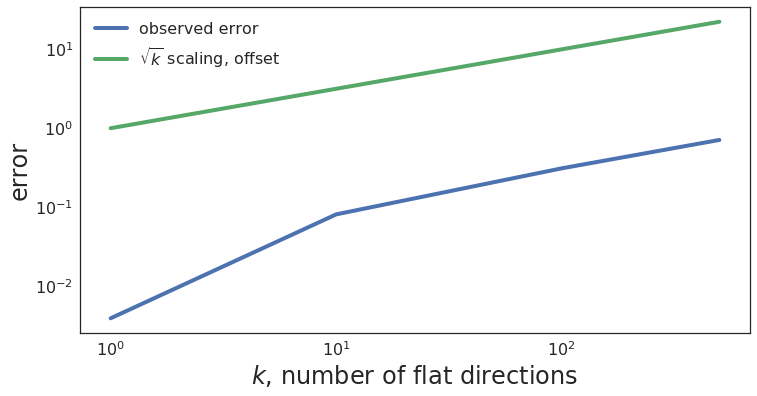

In [38]:
errors = [results[-1] for results in [one_flat_results, ten_flat_results, hundred_flat_results, half_flat_results]]
plt.figure(figsize=(12,6));
plt.loglog([1,10,100,500], errors, label="observed error", linewidth=4);
plt.loglog([1,10,100,500], np.power([1,10,100,500],0.5), label=r"$\sqrt{k}$ scaling, offset", linewidth=4);
plt.legend(fontsize=16);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel("$k$, number of flat directions", fontsize=24);
plt.ylabel("error", fontsize=24);

### Random Negative Definite Matrix

The Newton method is designed to optimize convex functions. For functions with directions of negative curvature, it does exactly the opposite of what it should, from an optimizer's perspective: when the gradient says go down, it actually says go up! This causes it to be attaracted to maxima in this case. For a negative definite quadratic form, this maximum is at $0$.

So if we try to run the Newton method in such a case, we should actually "pessimize", rather than optimize, the function. Gradient descent, even with just one step, will almost surely do better.

For our work, this is a *good thing*, since it means we've found a place where the gradient is close to a $0$: a numerical critical point, but one that is not a minimum (or even a saddle!).

In [39]:
def generate_negative_wishart(N):
    wishart_random_matrix = generate_wishart(N)
    negative_wishart_random_matrix = -1*wishart_random_matrix
    
    return negative_wishart_random_matrix

In [40]:
N = 5

negative_wishart_random_matrix = generate_negative_wishart(N)

initial_values = np.random.standard_normal(size=N)

negative_wishart_quadratic_form = crit_finder.make_quadratic_form(
                                                    negative_wishart_random_matrix, initial_values,
                                                                 {"learning_rate":0.1,
                                                                 "newton_rate":1,
                                                                 "fudge_factor":10e-7,
                                                                 "inverse_method":"fudged"})

In [41]:
crit_finder.minimize(negative_wishart_quadratic_form, "newton", 1)

(-0.0005092413,
 array([-0.5494853 ,  0.9749731 ,  2.162648  ,  0.07358068,  0.2071239 ],
       dtype=float32))

In [42]:
crit_finder.minimize(negative_wishart_quadratic_form, "gradient_descent", 1)

(-1.0137134,
 array([-1.2876868 ,  0.13002202,  2.355134  ,  0.57956755,  0.1279619 ],
       dtype=float32))

In [43]:
crit_finder.gradient_test(N=5, matrix_generator=generate_negative_wishart, num_steps=2, algorithm="newton",
                          hyperparameters={"learning_rate":0.1,
                                         "newton_rate":1,
                                         "fudge_factor":10e-7,
                                         "inverse_method":"fudged"})

output:
	initial: -0.07057055830955505 	final: 3.174591256538406e-09
gradient norm:
	initial: 0.3125286102294922 	final: 1.869863990577869e-05


In [44]:
output, values = crit_finder.minimize(negative_wishart_quadratic_form, "newton", 10)

np.linalg.norm(values)/np.linalg.norm(initial_values)

0.9229846248555875

On a negative definite quadratic form,
our pseudo-method also finds a point with very small gradient.

In [45]:
crit_finder.gradient_test(N=5, matrix_generator=generate_negative_wishart, num_steps=2, algorithm="newton",
                          hyperparameters={"learning_rate":0.1,
                                         "newton_rate":1,
                                         "minimum_eigenvalue_magnitude":1e-6,
                                         "inverse_method":"pseudo"})

output:
	initial: -0.004998524207621813 	final: -1.9342673296396384e-11
gradient norm:
	initial: 0.09551560878753662 	final: 1.1124365872916542e-09
